# Trabalho 2 - Regressão Logística Bayesiana
---

A **Regressão Logística Bayesiana**, diferente da regressão logística, visa encontrar uma distribuição de probabilidade que represente os possíveis modelos lineares que representem os dados, ou seja, ao invés de encontrar um conjunto de pesos para representar o modelo, ela encontra a distribuição seguida pelos pesos que melhor representam os dados.

Para fins de tornar a explicação mais genérica, vamos representar os dados como $\Phi$, o qual representa os dados após ser aplicada uma função de base. Nas implementações vamos utilizar a função de base identidade $\Phi(x) = x$, para simplificar.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

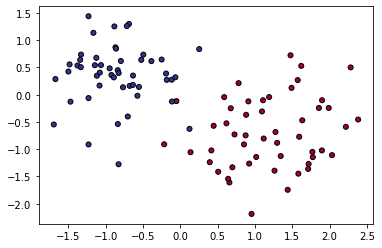

In [2]:
data = np.loadtxt("logistic_regression_data.csv", delimiter=",")
X, Y = data[:, 0:-1], data[:,-1]
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k', cmap=plt.cm.RdYlBu)

A solução para a regressão logística bayesiana, diferente da linear bayesiana, precisa ser *aproximada*. Isso ocorre pois a função logística, quando aplicada nas distribuições normais, não gera uma normal. Logo, não temos como calcular, definidamente, a integral para encontrar a posteriori.

Utilizando a aproximação o método de aproximação de Laplace, assumindo uma distribuição a priori $p(\textbf{w}) = \mathcal{N}(\textbf{w} | \textbf{m}_0, \textbf{S}_0)$, encontramos que a posteriori é uma distribuição normal $p(\textbf{w}|\mathcal{D}) = \mathcal{N}(\textbf{w} | \hat{\textbf{w}}, \textbf{H}^{-1})$, onde a média $\hat{\textbf{w}}$ são os pesos encontrados pelo método IRLS de máxima a posteriori e $\textbf{H} = \Phi^T \hat{\textbf{R}} \Phi + \textbf{S}_0^{-1}$, onde $\hat{\textbf{R}}$ é a matriz diagonal $\textbf{R}$ (definida a seguir), usando $\hat{\textbf{w}}$

### *Iteractive reweighted least squares* MAP(solução de máximo a posteriori)

Como a função logística adiciona uma não linearidade ao processo de otimização, não temos como utilizar os mínimos quadrados de maneira direta. Logo, podemos aproximar a solução minimizando a função de erro com o método de *Newton-Raphson*, de modo iterativo, calculando o vetor de pesos $\textbf{w}$ da seguinte forma:

$$\textbf{w}^{k+1} = \textbf{w}^k + \textbf{A}^{-1}[\Phi^T (\textbf{y} - \sigma (\Phi \textbf{w}^k)) - \textbf{S}_0^{-1}(\textbf{w}-\textbf{m}_0)]$$

$$ \textbf{A} = \Phi^T \textbf{R}^k \Phi + \textbf{S}_0^{-1}$$

$$\textbf{R}_{nn}^k = y_n^k(1-y_n^k)$$

$$ y_n^k = \sigma((\textbf{w}^k)^T \Phi_n) $$

In [3]:
def logistic_function(a):
    return 1/(1+np.exp(-1*a))

def add_bias_parameter(x):
    '''Adiciona os termos independentes (parâmetro bias) aos dados'''
    return np.concatenate([np.ones((x.shape[0],1)), x], axis=1)

def R(x,w):
    prediction = logistic_function(x.dot(w))
    return np.diag(np.multiply(prediction, (1-prediction)).ravel())

def A(x,w,S_inv):
    r = R(x,w)
    return x.T.dot(r).dot(x) + S_inv

def IRLS_map(x,y, m, S, tol=1e-3, maxiter=100):
    w = np.zeros(x.shape[1]).reshape(-1,1)
    previous_w = None
    i = 0
    S_inv = np.linalg.inv(S)
    m = m.reshape(-1,1)
    y = y.reshape(-1,1)
    
    while i < maxiter and (previous_w is None or not all(np.isclose(w,previous_w, rtol=tol))):
        previous_w = np.copy(w)
        a = A(x,w,S_inv)
        prediction = logistic_function(x.dot(w))
        
        aux = x.T.dot(y-prediction) - S_inv.dot(w - m)
        
        w = w + np.linalg.inv(a).dot(aux)
        i += 1

    return w.ravel()

def posteriori(x,y, m, S):
    w_hat = IRLS_map(x,y,m,S)
    
    S_inv = np.linalg.inv(S)
    r_hat = R(x,w_hat)
    H = x.T.dot(r_hat).dot(x) + S_inv
    
    return w_hat, np.linalg.inv(H)

In [4]:
mean_0 = np.array([0,0,0])
var_0 = np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1]
])
mean, var = posteriori(add_bias_parameter(X),Y, mean_0, var_0)
mean, var

(array([ 0.51531419, -2.81281331,  1.44860202]),
 array([[ 0.16799293, -0.00697522,  0.04936449],
        [-0.00697522,  0.28886403,  0.03014287],
        [ 0.04936449,  0.03014287,  0.32381187]]))

### Distribuição preditiva

Assim como a posteriori, a distribuição preditiva também precisa ser aproximada. Para isso, podemos utilziar dois métodos de aproximação:

* Aproximação de **Monte Carlo**, onde $p(y = 1 | x) \approx \frac{1}{S} \sum_{s=1}^{S} \sigma(\textbf{w}_s^T \phi)$, onde $S$ é um número pré-determinado de testes e $\textbf{w}_S$ é o *s-ésimo* vetor de pesos, obtido aleatóriamente seguindo a distribuição de pesos a posteriori calculada  

* Aproximação **probit** $p(y = 1 | x) \approx \sigma((1 + \frac{\pi \sigma^2_a}{8})^{\frac{1}{2}} \mu_a)$

In [5]:
# os modelos de monte carlo são pré-computados, para garantir que todos os dados serão testados com os mesmos modelos
monte_carlo_models = np.random.multivariate_normal(mean.ravel(), var, 5).T
def predict_monte_carlo(x, m, S):
    y = np.sum(logistic_function(x.dot(monte_carlo_models)), axis=1)    
    return y/monte_carlo_models.shape[1]

def predict_probit(x, m, S):

    m_a = x.dot(m)
    sigma_a = x.dot(S).dot(x.T)
    
    y = logistic_function(np.sqrt(1 + np.pi*sigma_a/8).dot(m_a))
    
    return y


Para gerar as superfícies de densidade da decisão, devido a grande quantidade de pontos para serem calculados, as predições a posteriori estavam dando *NaN*. Portanto, para evitar esse problema, fiz uma função que faz a predição de cada amostra individualmente. Os resultados, por sua vez, ficam um pouco diferentes assim, mas a superfície gerada condiz com o esperado

In [6]:
def isolated_prediction(X,mean,S, approximation_function):
    y = []
    for x in X:
        y.append(approximation_function(x.reshape(1,-1),mean,var))
        
    return np.array(y).ravel()

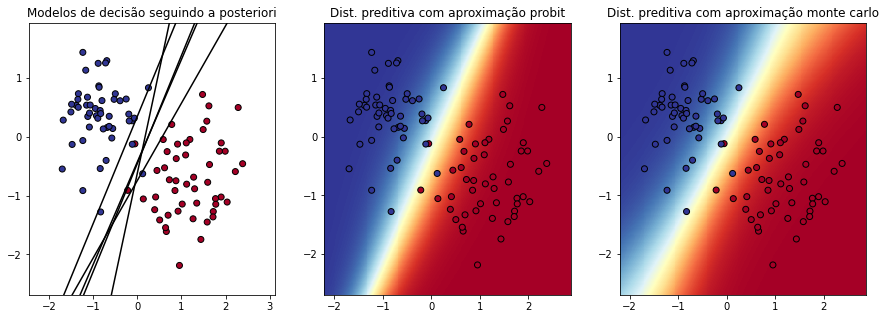

In [7]:
# definindo a superfície de decisão, para plotar as densidades
margin = 0.5
cmap = plt.cm.RdYlBu
x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
h = .02  # tamanho da célula da superfície de densidade
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# obtendo amostras de modelos que seguem a posteriori
models_samples = np.random.multivariate_normal(mean.ravel(), var, 5) # como w segue uma distribuição normal, os modelos gerados aleatoriamente seguind oessa distruibuição representam bem os dados

# PLOTS
plt.figure(figsize=(15,5))

# plot dos dados com os logits dos modelos
plt.subplot(1,3,1)
for w in models_samples:
    # para cada modelo, o logit é computado pela fórmula abaixo
    y = -w[1] * xx[0] / w[2] - w[0] / w[2]
    plt.plot(xx[0],y, "k-")
    
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=cmap)
plt.ylim(y_min, y_max)
plt.title("Modelos de decisão seguindo a posteriori")

# plot dos dados e da distribuição preditiva com aproximação probit
Z_probit = isolated_prediction(add_bias_parameter(np.c_[xx.ravel(), yy.ravel()]), mean, var, predict_probit).reshape(xx.shape)
plt.subplot(1,3,2)
plt.pcolormesh(xx, yy, Z_probit, cmap=cmap, shading="auto")
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=cmap)
_ = plt.title("Dist. preditiva com aproximação probit")

# plot dos dados e da distribuição preditiva com aproximação de monte carlo
Z_monte_carlo = isolated_prediction(add_bias_parameter(np.c_[xx.ravel(), yy.ravel()]), mean, var, predict_monte_carlo).reshape(xx.shape)
plt.subplot(1,3,3)
plt.pcolormesh(xx, yy, Z_monte_carlo, cmap=cmap, shading="auto")
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=cmap)
_ = plt.title("Dist. preditiva com aproximação monte carlo")